<a href="https://colab.research.google.com/github/alexgaarciia/SyntheticTrafficRouting/blob/main/statistical_similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [54]:
# Check if running in Google Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# If in Google Colab, clone the repository
if IN_COLAB:
    !git clone https://github.com/alexgaarciia/SyntheticTrafficRouting.git
    import os
    os.chdir('SyntheticTrafficRouting/')
    print("Repository cloned!")
else:
    print("Not in Google Colab, skipping repository clone.")

Not in Google Colab, skipping repository clone.


In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sdv.metadata import SingleTableMetadata
from sdv.evaluation.single_table import evaluate_quality
from sdv.evaluation.single_table import get_column_plot
from functions import rescale_demand

# Load real and synthetic data

In [100]:
combined_data = pd.read_csv("real_data.csv", sep=",")
synthetic_data_sdv = pd.read_csv("synthetic_data_sdv.csv", sep=",")
synthetic_data_gan = pd.read_csv("synthetic_data_gan.csv", sep=",")

In [4]:
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(combined_data)

# Measure the statistical similarity between real and synthetic data

## SDV Generated Data

In [5]:
quality_report = evaluate_quality(
    combined_data,
    synthetic_data_sdv,
    metadata)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 3/3 [00:00<00:00, 105.94it/s]|
Column Shapes Score: 92.43%

(2/2) Evaluating Column Pair Trends: |██████████| 3/3 [00:00<00:00, 93.04it/s]|
Column Pair Trends Score: 71.4%

Overall Score (Average): 81.91%



In [6]:
fig = get_column_plot(
    real_data=combined_data,
    synthetic_data=synthetic_data_sdv,
    column_name='source',
    metadata=metadata
)

fig.show()

In [7]:
fig = get_column_plot(
    real_data=combined_data,
    synthetic_data=synthetic_data_sdv,
    column_name='target',
    metadata=metadata
)

fig.show()

## GAN Generated Data

In [8]:
quality_report2 = evaluate_quality(
    combined_data,
    synthetic_data_gan,
    metadata)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 3/3 [00:00<00:00, 181.74it/s]|
Column Shapes Score: 89.22%

(2/2) Evaluating Column Pair Trends: |██████████| 3/3 [00:00<00:00, 59.70it/s]|
Column Pair Trends Score: 81.1%

Overall Score (Average): 85.16%



In [9]:
fig = get_column_plot(
    real_data=combined_data,
    synthetic_data=synthetic_data_gan,
    column_name='source',
    metadata=metadata
)

fig.show()

In [10]:
fig = get_column_plot(
    real_data=combined_data,
    synthetic_data=synthetic_data_gan,
    column_name='target',
    metadata=metadata
)

fig.show()

# Link load comparison

To further extent the comparison between the real data and the synthetic data, we want to see how much does the link load (demand_value) varies between these two.

To do so, we will follow this approach:
1. For each dataset (real and synthetic), we will create a new dataset that stores, for each unique source-destination pair, the total link load. This is computed by summing up the demand value for each unique pair.
2. Calculate the absolute and relative difference in link loads.

$$
AD = |y - \hat{y}|
$$

$$
RD = \left| \frac{y - \hat{y}}{y} \right|
$$

In [101]:
# Mbits/s to Gbits/s
combined_data["demand_value"] = combined_data["demand_value"]/1000
synthetic_data_gan["demand_value"] = synthetic_data_gan["demand_value"]/1000
synthetic_data_sdv["demand_value"] = synthetic_data_sdv["demand_value"]/1000

# Scale datasets to reflect actual traffic demand
growth_factor = (1 + 0.45) ** (2025 - 2004)
combined_data = rescale_demand(combined_data, growth_factor)
synthetic_data_gan = rescale_demand(synthetic_data_gan, growth_factor)
synthetic_data_sdv = rescale_demand(synthetic_data_sdv, growth_factor)

In [102]:
# Group by source and target
real_clean = combined_data.groupby(["source", "target"])["demand_value"].sum().reset_index()
synthetic_gan_clean = synthetic_data_gan.groupby(["source", "target"])["demand_value"].sum().reset_index()
synthetic_sdv_clean = synthetic_data_sdv.groupby(["source", "target"])["demand_value"].sum().reset_index()

In [103]:
# Filter out rows with same source and destination
synthetic_gan_clean = synthetic_gan_clean[synthetic_gan_clean["source"] != synthetic_gan_clean["target"]]
synthetic_sdv_clean = synthetic_sdv_clean[synthetic_sdv_clean["source"] != synthetic_sdv_clean["target"]]

In [105]:
# Merge datasets
df_comparison_temp = pd.merge(real_clean, synthetic_gan_clean,
                         on=["source", "target"],
                         how="outer",
                         suffixes=("_real", "_gan")).fillna(0)

df_comparison = pd.merge(df_comparison_temp, synthetic_sdv_clean,
                         on=["source", "target"],
                         how="outer").fillna(0)

df_comparison.rename(columns={"demand_value": "demand_value_sdv"}, inplace=True)

In [106]:
# Calculate the absolute and relative differences
df_comparison["abs_diff_gan"] = abs(
    df_comparison["demand_value_real"] - df_comparison["demand_value_gan"])
df_comparison["rel_diff_gan"] = df_comparison["abs_diff_gan"] / df_comparison["demand_value_real"]

df_comparison["abs_diff_sdv"] = abs(
    df_comparison["demand_value_real"] - df_comparison["demand_value_sdv"])
df_comparison["rel_diff_sdv"] = df_comparison["abs_diff_sdv"] / df_comparison["demand_value_real"]

In [107]:
df_comparison

source  target  demand_value_real  demand_value_gan  demand_value_sdv  \
0    ATLAM5  ATLAng          42.916545          2.545895        237.557402   
1    ATLAM5  CHINng         185.454931         40.562281       3504.306451   
2    ATLAM5  DNVRng          23.576842         37.688160        601.887037   
3    ATLAM5  HSTNng          89.040615        554.679915        424.961864   
4    ATLAM5  IPLSng         101.174209        399.956654        342.413325   
..      ...     ...                ...               ...               ...   
127  WASHng  KSCYng        6400.367079      36249.493881      14770.755985   
128  WASHng  LOSAng       29387.753755      67617.633294      11667.087921   
129  WASHng  NYCMng       50145.664952      42328.449864      14251.293639   
130  WASHng  SNVAng         963.929214      14745.513969       3598.037880   
131  WASHng  STTLng       11082.325606      13725.621401       8237.909584   

     abs_diff_gan  rel_diff_gan  abs_diff_sdv  rel_diff_sdv  
0       40.370651      0.940678    194.640857      4.535334  
1      144.892650      0.781282   3318.851520     17.895731  
2       14.111317      0.598524    578.310195     24.528738  
3      465.639300      5.229516    335.921249      3.772674  
4      298.782446      2.953148    241.239116      2.384393  
..            ...           ...           ...           ...  
127  29849.126802      4.663659   8370.388905      1.307798  
128  38229.879539      1.300878  17720.665834      0.602995  
129   7817.215089      0.155890  35894.371314      0.715802  
130  13781.584755     14.297300   2634.108666      2.732679  
131   2643.295795      0.238515   2844.416021      0.256662  

[132 rows x 9 columns]

In [108]:
mad_gan = df_comparison['abs_diff_gan'].mean()
mrd_gan = df_comparison['rel_diff_gan'].mean()
print(f"Mean Absolute Difference (GAN): {mad_gan}")
print(f"Mean Relative Difference (GAN): {mrd_gan}")
print()

mad_sdv = df_comparison['abs_diff_sdv'].mean()
mrd_sdv = df_comparison['rel_diff_sdv'].mean()
print(f"Mean Absolute Difference (SDV): {mad_sdv}")
print(f"Mean Relative Difference (SDV): {mrd_sdv}")

Mean Absolute Difference (GAN): 8063.93438927131
Mean Relative Difference (GAN): 5.769206010721678

Mean Absolute Difference (SDV): 4620.748953320343
Mean Relative Difference (SDV): 2.393097584057493


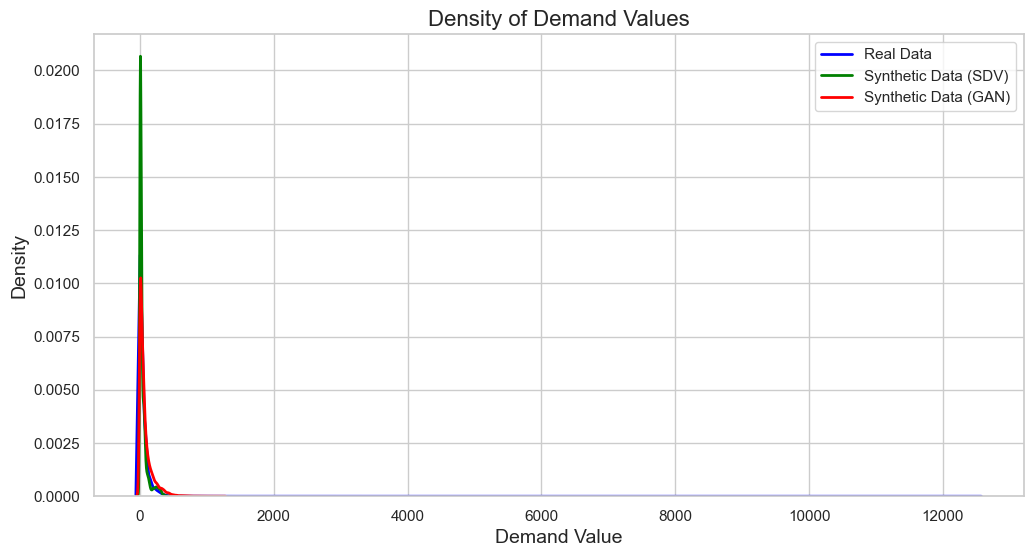

In [109]:
# Set the style for the plots
sns.set(style="whitegrid")

# Create a figure and axis object
plt.figure(figsize=(12, 6))

# Plot the density for 'demand_value' from real and synthetic data
sns.kdeplot(combined_data['demand_value'], color='blue', label='Real Data', linewidth=2)
sns.kdeplot(synthetic_data_sdv['demand_value'], color='green', label='Synthetic Data (SDV)', linewidth=2)
sns.kdeplot(synthetic_data_gan['demand_value'], color='red', label='Synthetic Data (GAN)', linewidth=2)

# Add labels and title
plt.title('Density of Demand Values', fontsize=16)
plt.xlabel('Demand Value', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend()
plt.show()

# Lowest link load comparison

In [110]:
# Group by 'source' and 'target', then get the minimum 'demand_value' for each group
min_demand_real = combined_data.loc[combined_data.groupby(['source', 'target'])['demand_value'].idxmin()]
min_demand_gan = synthetic_data_gan.loc[synthetic_data_gan.groupby(['source', 'target'])['demand_value'].idxmin()]
min_demand_sdv = synthetic_data_sdv.loc[synthetic_data_sdv.groupby(['source', 'target'])['demand_value'].idxmin()]

In [111]:
# Filter out rows with same source and destination
min_demand_gan = min_demand_gan[min_demand_gan["source"] != min_demand_gan["target"]]
min_demand_sdv = min_demand_sdv[min_demand_sdv["source"] != min_demand_sdv["target"]]

In [112]:
# Merge datasets
df_min_comparison_temp = pd.merge(min_demand_real, min_demand_gan,
                         on=["source", "target"],
                         how="outer",
                         suffixes=("_min_real", "_min_gan")).fillna(0)

df_min_comparison = pd.merge(df_min_comparison_temp, min_demand_sdv,
                         on=["source", "target"],
                         how="outer").fillna(0)

df_min_comparison.rename(columns={"demand_value": "demand_value_min_sdv"}, inplace=True)

In [113]:
# Calculate the absolute and relative differences
df_min_comparison["abs_diff_gan"] = abs(
    df_min_comparison["demand_value_min_real"] - df_min_comparison["demand_value_min_gan"])
df_min_comparison["rel_diff_gan"] = df_min_comparison["abs_diff_gan"] / df_min_comparison["demand_value_min_real"]

df_min_comparison["abs_diff_sdv"] = abs(
    df_min_comparison["demand_value_min_real"] - df_min_comparison["demand_value_min_sdv"])
df_min_comparison["rel_diff_sdv"] = df_min_comparison["abs_diff_sdv"] / df_min_comparison["demand_value_min_real"]

In [114]:
df_min_comparison

source  target  demand_value_min_real  demand_value_min_gan  \
0    ATLAM5  ATLAng               0.065268              0.032680   
1    ATLAM5  CHINng               0.065268              0.032673   
2    ATLAM5  DNVRng               0.065268              0.034180   
3    ATLAM5  HSTNng               0.065268              0.033369   
4    ATLAM5  IPLSng               0.065268              0.032927   
..      ...     ...                    ...                   ...   
127  WASHng  KSCYng               0.117168             33.443989   
128  WASHng  LOSAng               0.065268              0.397162   
129  WASHng  NYCMng               3.404456              0.879095   
130  WASHng  SNVAng               0.065268              1.084498   
131  WASHng  STTLng               0.280604              4.998530   

     demand_value_min_sdv  abs_diff_gan  rel_diff_gan  abs_diff_sdv  \
0                0.032633      0.032588      0.499295      0.032635   
1                0.032633      0.032595      0.499399      0.032635   
2                0.032633      0.031089      0.476323      0.032635   
3                0.032633      0.031900      0.488749      0.032635   
4                0.032633      0.032341      0.495510      0.032635   
..                    ...           ...           ...           ...   
127              0.032633     33.326821    284.435808      0.084535   
128              0.190521      0.331893      5.085062      0.125252   
129              3.046969      2.525361      0.741781      0.357486   
130              0.032633      1.019229     15.615995      0.032635   
131              0.032633      4.717925     16.813439      0.247972   

     rel_diff_sdv  
0        0.500019  
1        0.500019  
2        0.500019  
3        0.500019  
4        0.500019  
..            ...  
127      0.721486  
128      1.919039  
129      0.105005  
130      0.500019  
131      0.883705  

[132 rows x 9 columns]

In [115]:
mad_gan = df_min_comparison['abs_diff_gan'].mean()
mrd_gan = df_min_comparison['rel_diff_gan'].mean()
print(f"Mean Absolute Difference (GAN): {mad_gan}")
print(f"Mean Relative Difference (GAN): {mrd_gan}")
print()

mad_sdv = df_min_comparison['abs_diff_sdv'].mean()
mrd_sdv = df_min_comparison['rel_diff_sdv'].mean()
print(f"Mean Absolute Difference (SDV): {mad_sdv}")
print(f"Mean Relative Difference (SDV): {mrd_sdv}")

Mean Absolute Difference (GAN): 8.22036528866823
Mean Relative Difference (GAN): 35.30473323518556

Mean Absolute Difference (SDV): 3.6987977210921854
Mean Relative Difference (SDV): 3.0841688025916345


# Mean, Median, STD Comparison

In [82]:
combined_data.describe(), synthetic_data_gan.describe(), synthetic_data_sdv.describe()

(       demand_value
 count  20514.000000
 mean      44.424438
 std      149.293996
 min        0.032633
 25%        3.636665
 50%       17.372765
 75%       52.219122
 max    12513.544081,
        demand_value
 count  20514.000000
 mean      77.682132
 std      103.919404
 min        0.032633
 25%        9.210180
 50%       40.666128
 75%      100.420026
 max     1235.072789,
        demand_value
 count  20514.000000
 mean      41.924102
 std       64.134014
 min        0.032633
 25%        4.916364
 50%       17.770184
 75%       51.445368
 max      413.755416)